# Prediksi Hasil Panen Tanaman (Regresi)
## 1. Persiapan dan Pengunduhan Dataset

In [1]:
# Install library yang diperlukan
%pip install kaggle
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Memanggil dependensi
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [8]:
# Download dataset dari Kaggle
dataset_name = "patelris/crop-yield-prediction-dataset"
dataset_files = ["pesticides.csv", "rainfall.csv", "temp.csv", "yield.csv", "yield_df.csv"]

# Cek apakah semua file sudah ada
missing_files = [f for f in dataset_files if not os.path.exists(f)]

if missing_files:
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(
            dataset_name,
            path='.',
            unzip=True
        )
        print("✅ Dataset berhasil di-download!")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Pastikan Anda sudah:")
        print("1. Menginstal kaggle API")
        print("2. Memiliki token kaggle.json di ~/.kaggle/")
        # Untuk Google Colab, upload manual kaggle.json
        from google.colab import files
        print("\n🔑 Silakan upload kaggle.json Anda")
        files.upload()
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        # Coba download lagi
        api.dataset_download_files(dataset_name, path='.', unzip=True)
else:
    print("✅ Semua file dataset sudah tersedia lokal")

# Muat dan gabungkan dataset
# File utama yang akan kita gunakan: yield_df.csv
if os.path.exists("yield_df.csv"):
    df = pd.read_csv("yield_df.csv")
    print("🖥️ Menggunakan file yield_df.csv")
else:
    print("⚠️ File yield_df.csv tidak ditemukan, mencoba gabungkan file terpisah")
    
    # Muat masing-masing dataset
    yield_data = pd.read_csv("yield.csv")
    rainfall_data = pd.read_csv("rainfall.csv")
    temp_data = pd.read_csv("temp.csv")
    pesticides_data = pd.read_csv("pesticides.csv")
    
    # Gabungkan dataset
    df = yield_data.merge(rainfall_data, on=['Year', 'Area'])
    df = df.merge(temp_data, on=['Year', 'Area'])
    df = df.merge(pesticides_data, on=['Year', 'Area'])
    
    # Simpan hasil gabungan untuk analisis
    df.to_csv("combined_yield_data.csv", index=False)
    print("✅ File gabungan disimpan sebagai combined_yield_data.csv")

print("\n🖥️ 5 Baris pertama dataset:")
display(df.head())

✅ Semua file dataset sudah tersedia lokal
🖥️ Menggunakan file yield_df.csv

🖥️ 5 Baris pertama dataset:


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


## 2. Eksplorasi Data dan Seleksi Fitur

In [12]:
# Tampilkan informasi dataset
print("\n📊 Informasi dataset:")
print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")
print("\n🔍 Kolom yang tersedia:")
print(df.columns.tolist())

# Statistik deskriptif
print("\n📈 Statistik deskriptif:")
display(df.describe())

# Analisis kolom yang tersedia
print("\n🔎 Analisis kolom:")
print("Kolom yang ada:", df.columns.tolist())

# Periksa apakah kolom target ada
if 'hg/ha_yield' in df.columns:
    target = 'hg/ha_yield'
    print(f"\n🎯 Kolom target: '{target}'")
else:
    # Jika kolom target tidak ada, cari alternatif
    possible_targets = ['yield', 'production', 'value']
    for col in possible_targets:
        if col in df.columns:
            target = col
            print(f"⚠️ Kolom 'hg/ha_yield' tidak ditemukan, menggunakan alternatif: '{target}'")
            break
    else:
        target = df.columns[-1]  # Gunakan kolom terakhir sebagai fallback
        print(f"⚠️ Kolom target tidak ditemukan, menggunakan kolom terakhir: '{target}'")

# Pilih fitur yang relevan
features = []
possible_features = {
    'rainfall': ['average_rain_fall_mm_per_year', 'rainfall', 'precipitation'],
    'pesticide': ['pesticides_tonnes', 'pesticide', 'pesticide_use'],
    'temperature': ['avg_temp', 'temperature', 'mean_temp'],
    'area': ['Area', 'area_hectares', 'cultivated_area']
}

# Cari kolom yang sesuai untuk setiap fitur
for feature_type, alternatives in possible_features.items():
    for alt in alternatives:
        if alt in df.columns:
            features.append(alt)
            print(f"✅ Fitur {feature_type}: menggunakan kolom '{alt}'")
            break
    else:
        print(f"⚠️ Tidak ditemukan kolom untuk fitur {feature_type}")

print("\n📌 Fitur yang dipilih:", features)
print("🎯 Target:", target)

# Cek missing values
print("\n🔎 Missing values:")
print(df[features + [target]].isnull().sum())

# Handle missing values (jika ada)
df_clean = df[features + [target]].dropna()

print("\n🧹 Data setelah cleaning:")
print(f"Jumlah baris: {df_clean.shape[0]}")


📊 Informasi dataset:
Jumlah baris: 28242, Jumlah kolom: 8

🔍 Kolom yang tersedia:
['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

📈 Statistik deskriptif:


,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,14120.500000,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,28241.000000,2013.000000,501412.000000,3240.00000,367778.000000,30.650000



🔎 Analisis kolom:
Kolom yang ada: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

🎯 Kolom target: 'hg/ha_yield'
✅ Fitur rainfall: menggunakan kolom 'average_rain_fall_mm_per_year'
✅ Fitur pesticide: menggunakan kolom 'pesticides_tonnes'
✅ Fitur temperature: menggunakan kolom 'avg_temp'
✅ Fitur area: menggunakan kolom 'Area'

📌 Fitur yang dipilih: ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Area']
🎯 Target: hg/ha_yield

🔎 Missing values:
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
Area                             0
hg/ha_yield                      0
dtype: int64

🧹 Data setelah cleaning:
Jumlah baris: 28242


## 3. Analisis dan Visualisasi Data


🔢 Kolom numerik yang tersedia:
['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'hg/ha_yield']


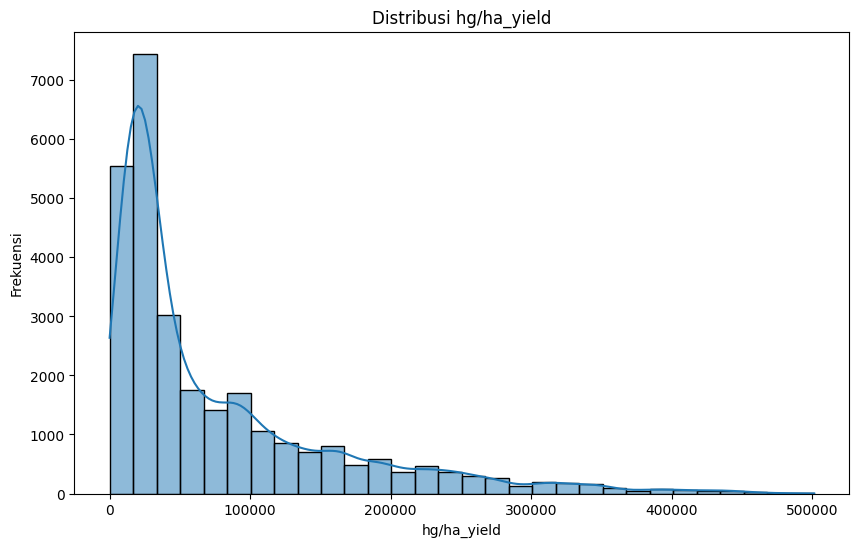

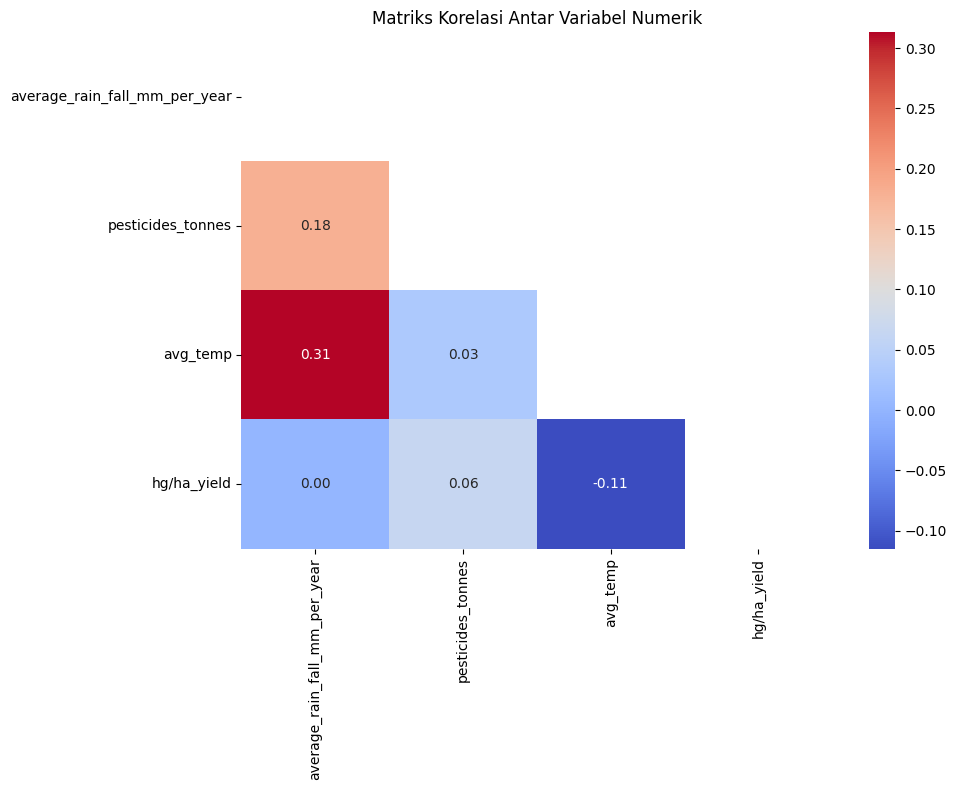

⏳ Membuat pairplot untuk variabel numerik...


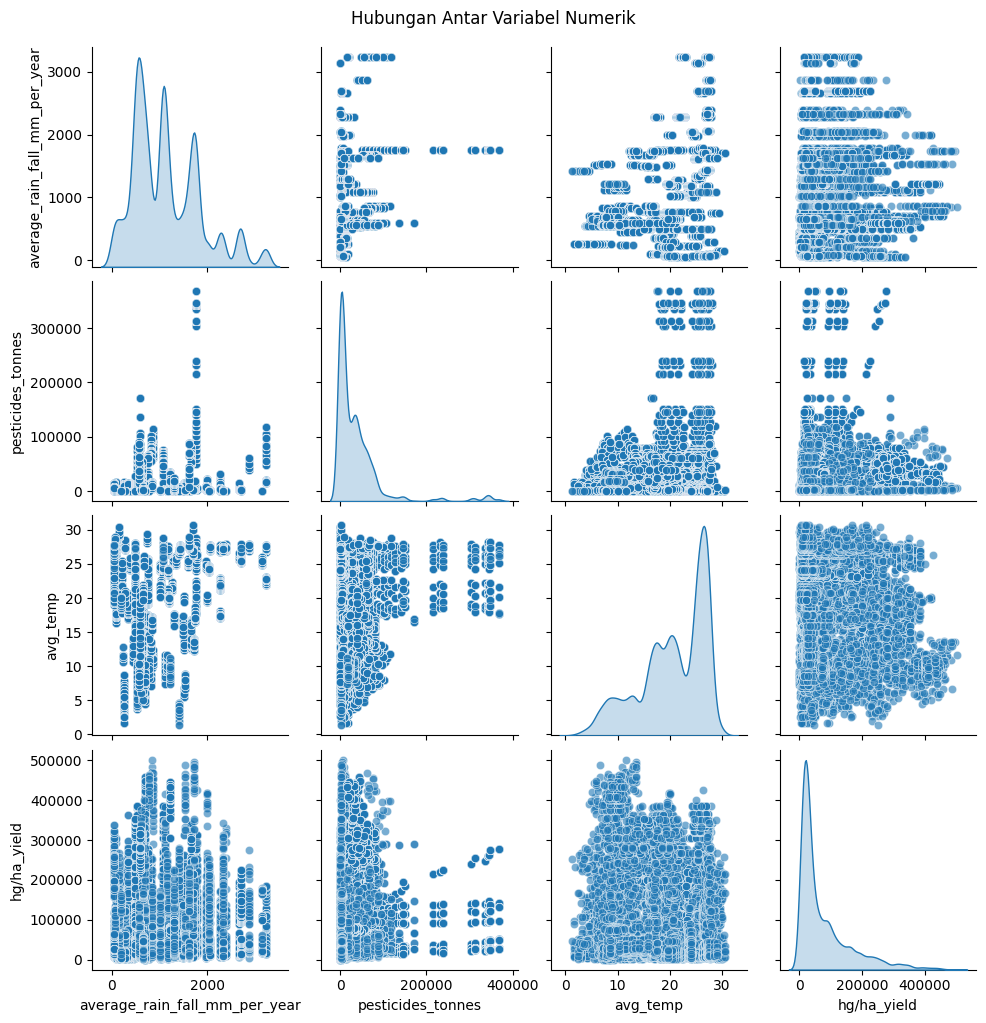

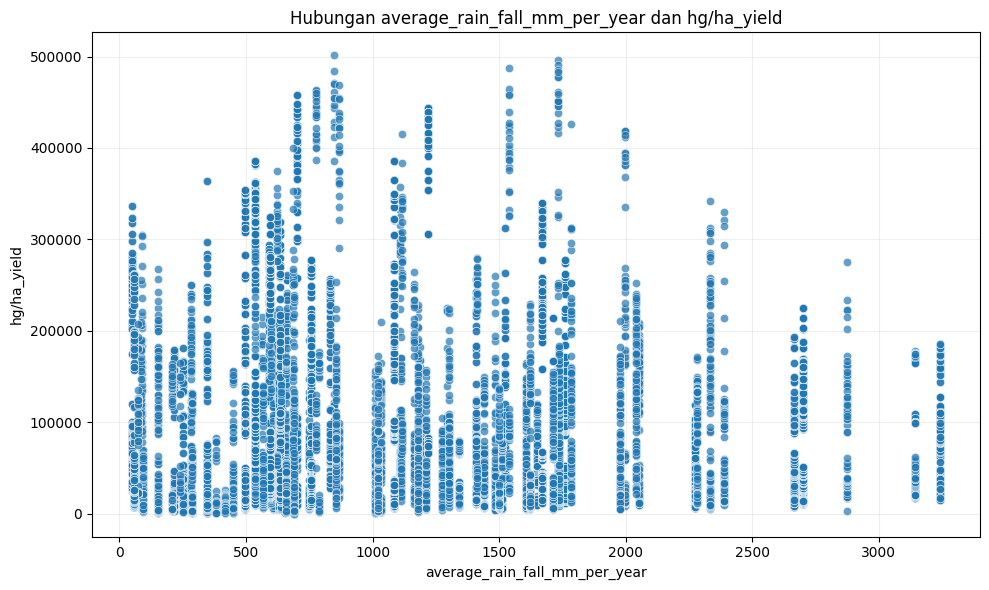

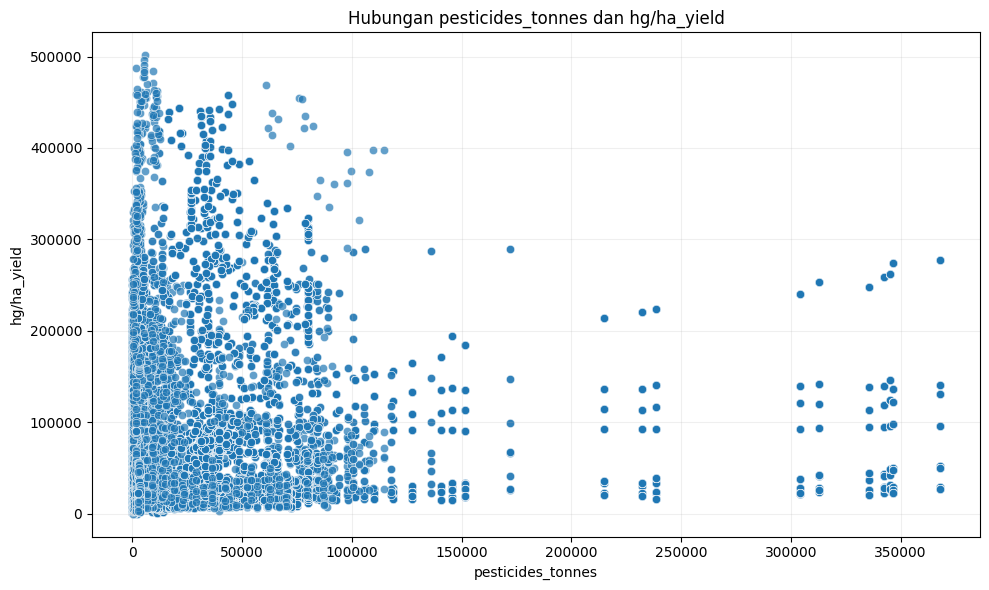

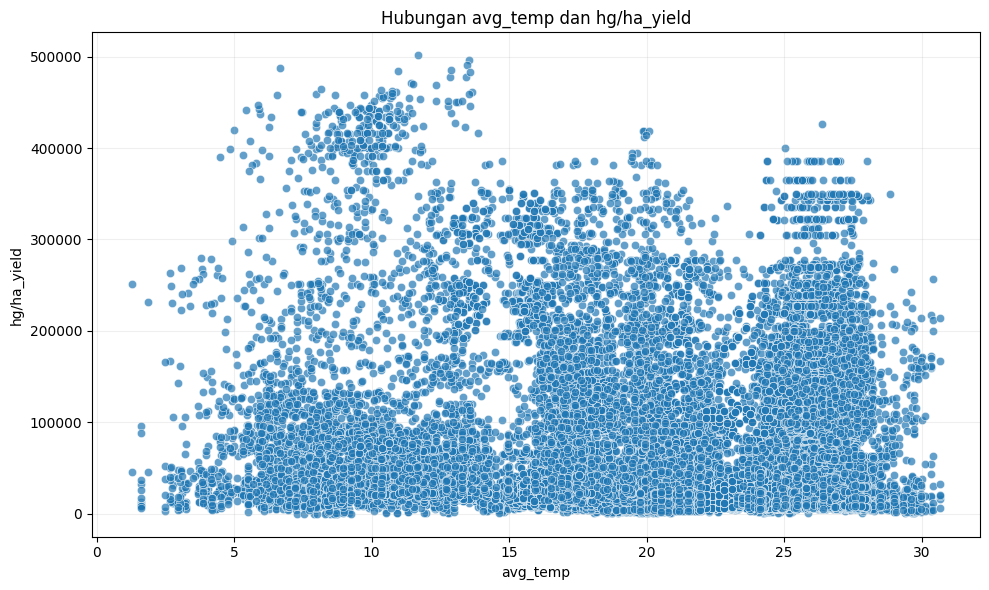

In [24]:
# Pastikan kita hanya menggunakan kolom numerik
numerical_cols = df_clean.select_dtypes(include=['number']).columns
print("\n🔢 Kolom numerik yang tersedia:")
print(numerical_cols.tolist())

# Distribusi variabel target
plt.figure(figsize=(10, 6))
sns.histplot(df_clean[target], kde=True, bins=30)
plt.title(f'Distribusi {target}')
plt.xlabel(target)
plt.ylabel('Frekuensi')
plt.show()

# Matriks korelasi (hanya untuk kolom numerik)
plt.figure(figsize=(10, 8))
corr_matrix = df_clean[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Matriks Korelasi Antar Variabel Numerik')
plt.tight_layout()
plt.show()

# Pairplot untuk hubungan antar variabel numerik
print("⏳ Membuat pairplot untuk variabel numerik...")
sns.pairplot(df_clean[numerical_cols], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Hubungan Antar Variabel Numerik', y=1.02)
plt.show()

# Visualisasi hubungan dengan target untuk setiap fitur numerik
for feature in numerical_cols:
    if feature != target:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=feature, y=target, data=df_clean, alpha=0.7)
        plt.title(f'Hubungan {feature} dan {target}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

## 4. Persiapan Data dan Pembagian Dataset

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Pisahkan fitur numerik dan kategorikal
numerical_features = df_clean.select_dtypes(include=['number']).columns.drop(target)
categorical_features = df_clean.select_dtypes(exclude=['number']).columns

print("\n🔢 Fitur numerik:", numerical_features.tolist())
print("🔤 Fitur kategorikal:", categorical_features.tolist())

# Encode fitur kategorikal
df_preprocessed = df_clean.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_preprocessed[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le
    print(f"✅ Kolom '{col}' di-encode. Contoh mapping:", 
        dict(zip(le.classes_, le.transform(le.classes_))))

# Normalisasi fitur numerik
scaler = StandardScaler()
df_preprocessed[numerical_features] = scaler.fit_transform(df_preprocessed[numerical_features])

# Pisahkan fitur dan target
X = df_preprocessed.drop(columns=[target])
y = df_preprocessed[target]

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print("\n✂️ Pembagian dataset:")
print(f"Training set: {X_train.shape[0]} sampel")
print(f"Test set: {X_test.shape[0]} sampel")
print("\n📊 Distribusi target (training):")
print(y_train.describe())


🔢 Fitur numerik: ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
🔤 Fitur kategorikal: ['Area']
✅ Kolom 'Area' di-encode. Contoh mapping: {'Albania': np.int64(0), 'Algeria': np.int64(1), 'Angola': np.int64(2), 'Argentina': np.int64(3), 'Armenia': np.int64(4), 'Australia': np.int64(5), 'Austria': np.int64(6), 'Azerbaijan': np.int64(7), 'Bahamas': np.int64(8), 'Bahrain': np.int64(9), 'Bangladesh': np.int64(10), 'Belarus': np.int64(11), 'Belgium': np.int64(12), 'Botswana': np.int64(13), 'Brazil': np.int64(14), 'Bulgaria': np.int64(15), 'Burkina Faso': np.int64(16), 'Burundi': np.int64(17), 'Cameroon': np.int64(18), 'Canada': np.int64(19), 'Central African Republic': np.int64(20), 'Chile': np.int64(21), 'Colombia': np.int64(22), 'Croatia': np.int64(23), 'Denmark': np.int64(24), 'Dominican Republic': np.int64(25), 'Ecuador': np.int64(26), 'Egypt': np.int64(27), 'El Salvador': np.int64(28), 'Eritrea': np.int64(29), 'Estonia': np.int64(30), 'Finland': np.int64(31), 'France'

## 5. Pembuatan Model Regresi

In [21]:
%pip install Jinja2

  Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 726.7 kB/s eta 0:00:00a 0:00:01
Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Inisialisasi model-model yang akan dibandingkan
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector': SVR(),
    'K-Neighbors': KNeighborsRegressor()
}

# Dictionary untuk menyimpan hasil evaluasi
results = {}

# Training dan evaluasi setiap model
for name, model in models.items():
    print(f"\n⏳ Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Hitung metrik evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }
    
    print(f"✅ {name} selesai dilatih!")
    print(f"   - R² Score: {r2:.4f}")
    print(f"   - RMSE: {rmse:.4f}")

# Tampilkan hasil perbandingan model
results_df = pd.DataFrame(results).T.sort_values('R2', ascending=False)
print("\n🏆 Hasil Perbandingan Model:")
display(results_df.style.background_gradient(cmap='Blues', subset=['R2', 'RMSE']))


⏳ Melatih model Linear Regression...
✅ Linear Regression selesai dilatih!
   - R² Score: 0.0224
   - RMSE: 84208.0375

⏳ Melatih model Random Forest...
✅ Random Forest selesai dilatih!
   - R² Score: -0.2000
   - RMSE: 93297.3203

⏳ Melatih model Support Vector...
✅ Support Vector selesai dilatih!
   - R² Score: -0.2048
   - RMSE: 93484.5294

⏳ Melatih model K-Neighbors...
✅ K-Neighbors selesai dilatih!
   - R² Score: -0.1316
   - RMSE: 90598.8060

🏆 Hasil Perbandingan Model:


,MSE,RMSE,R2
Linear Regression,7090993575.251148,84208.037474,0.022427
K-Neighbors,8208143640.781427,90598.805957,-0.131585
Random Forest,8704389969.035639,93297.320267,-0.199998
Support Vector,8739357244.620817,93484.529440,-0.204818


## 6. Evaluasi Model


🔥 Model terbaik: Linear Regression


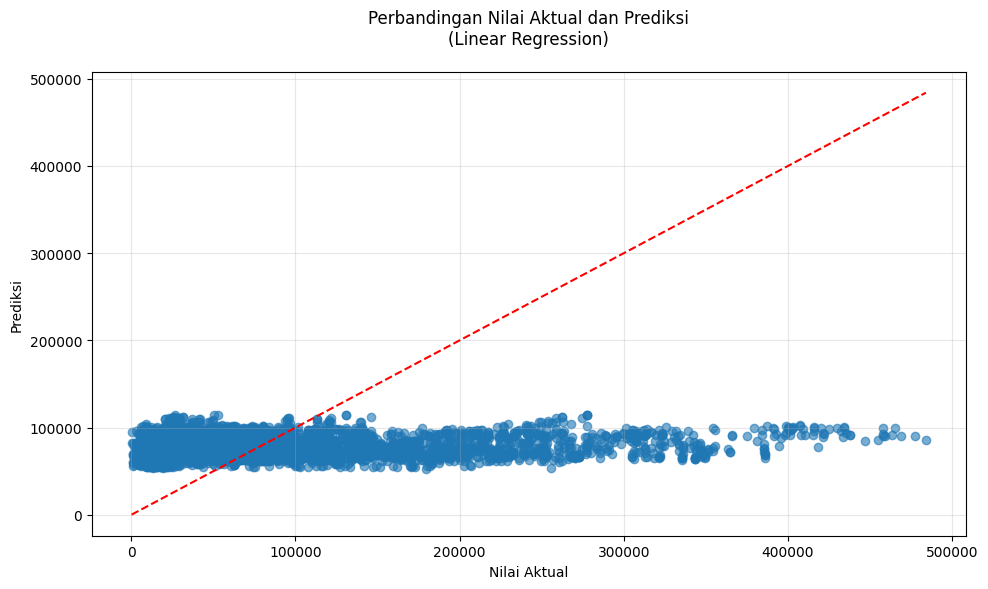

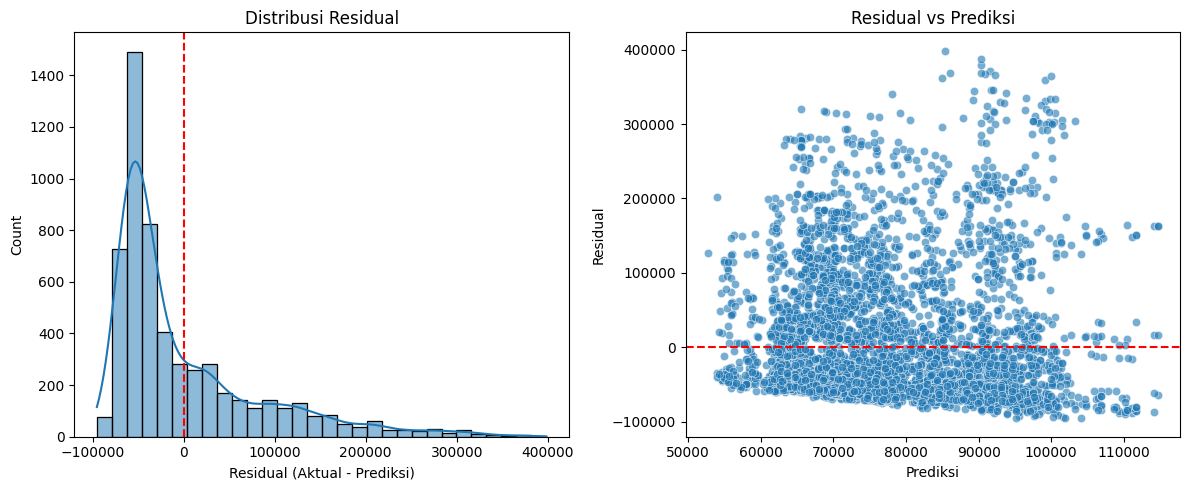

In [25]:
# Pilih model terbaik berdasarkan R² Score
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\n🔥 Model terbaik: {best_model_name}")

# Prediksi menggunakan model terbaik
y_pred = best_model.predict(X_test)

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Perbandingan Nilai Aktual dan Prediksi\n({best_model_name})', pad=20)
plt.xlabel('Nilai Aktual')
plt.ylabel('Prediksi')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribusi Residual')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs Prediksi')
plt.xlabel('Prediksi')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

## 7. Interpretasi dan Peningkatan Model

In [ ]:
# Feature importance untuk model tree-based
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    importances.sort_values().plot(kind='barh', color='teal')
    plt.title('Tingkat Kepentingan Fitur', pad=20)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    print("\n🔢 Koefisien Model Linear:")
    coef_df = pd.DataFrame({
        'Fitur': X.columns,
        'Koefisien': best_model.coef_.flatten()
    }).sort_values('Koefisien', key=abs, ascending=False)
    display(coef_df.style.bar(color=['red', 'green'], align='zero'))

# Contoh prediksi dengan data baru
sample_data = {
    'Year': [2023],
    'average_rain_fall_mm_per_year': [1200],
    'pesticides_tonnes': [150],
    'avg_temp': [25]
}

# Buat DataFrame contoh
sample_df = pd.DataFrame(sample_data)

# Preprocessing data contoh
sample_processed = sample_df.copy()

# Encode kolom kategorikal jika ada
for col in categorical_features:
    if col in sample_df.columns:
        sample_processed[col] = label_encoders[col].transform(sample_df[col])

# Scale kolom numerik
sample_processed[numerical_features] = scaler.transform(sample_processed[numerical_features])

# Prediksi
prediction = best_model.predict(sample_processed[X.columns])  # Pastikan urutan kolom sama

print("\n🌱 Contoh Prediksi:")
print("Input Data:")
display(sample_df)
print(f"\nPrediksi {target}: {prediction[0]:.2f}")

# Simpan model dan preprocessing objects
import joblib

artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'features': X.columns.tolist(),
    'target': target
}

joblib.dump(artifacts, 'crop_yield_model.pkl')
print("\n💾 Model berhasil disimpan sebagai 'crop_yield_model.pkl'")

print("\n💡 Interpretasi Hasil:")
print(f"- Model terbaik ({best_model_name}) mencapai R² sebesar {results[best_model_name]['R2']:.2%}")
print(f"- RMSE sebesar {results[best_model_name]['RMSE']:.2f} menunjukkan rata-rata kesalahan prediksi")
print("- Residual plot yang acak menunjukkan model yang cukup baik")
print("\n🚀 Saran untuk Peningkatan:")
print("1. Lakukan hyperparameter tuning untuk model terbaik")
print("2. Tambahkan feature engineering (polynomial features, dll)")
print("3. Pertimbangkan model ensemble seperti Gradient Boosting")
print("4. Evaluasi dengan cross-validation untuk hasil yang lebih robust")

usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: -y
Archive:  crop-yield-prediction-dataset.zip
caution: filename not matched:  -y
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  


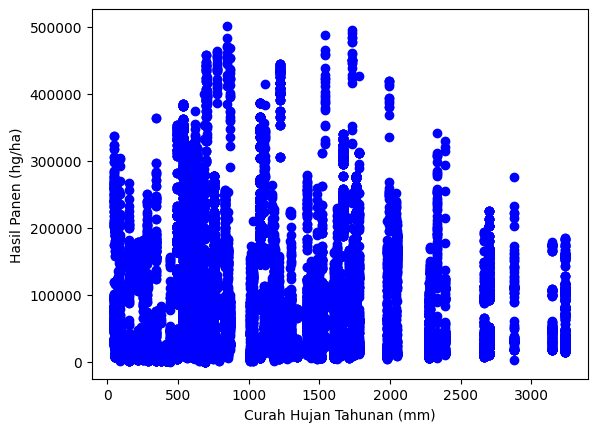

Koefisien: [[-0.24494623]]
Intercept: [77356.17283836]


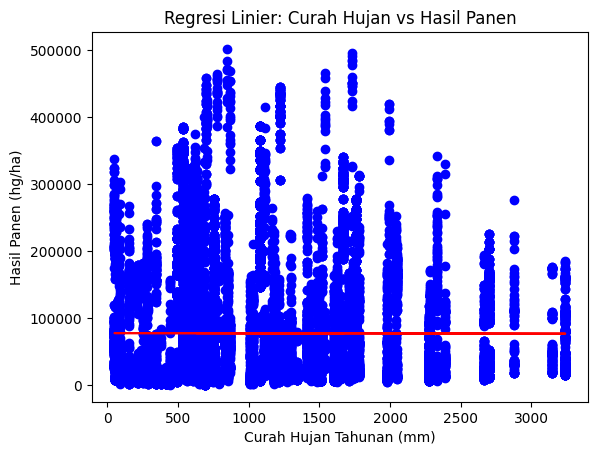

Mean Absolute Error: 7351558397.61
R2-score: -0.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Unduh dataset dari Kaggle (pastikan kaggle.json sudah diatur)
!kaggle datasets download -d patelris/crop-yield-prediction-dataset
!unzip crop-yield-prediction-dataset.zip -y

# Muat dataset
df = pd.read_csv("yield_df.csv")
print(df.head())

# Pilih kolom yang relevan
cdf = df[['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'hg/ha_yield']]
cdf.head(9)

# Plot hubungan curah hujan vs hasil panen
plt.scatter(cdf['average_rain_fall_mm_per_year'], cdf['hg/ha_yield'], color='blue')
plt.xlabel("Curah Hujan Tahunan (mm)")
plt.ylabel("Hasil Panen (hg/ha)")
plt.show()

# Bagi data (80% training, 20% testing)
train = cdf.sample(frac=0.8, random_state=42)
test = cdf.drop(train.index)

# Latih model regresi linier
regr = LinearRegression()
train_x = train[['average_rain_fall_mm_per_year']]
train_y = train[['hg/ha_yield']]
regr.fit(train_x, train_y)

# Koefisien model
print("Koefisien:", regr.coef_)
print("Intercept:", regr.intercept_)

plt.scatter(train_x, train_y, color='blue')
plt.plot(train_x, regr.predict(train_x), '-r')
plt.xlabel("Curah Hujan Tahunan (mm)")
plt.ylabel("Hasil Panen (hg/ha)")
plt.title("Regresi Linier: Curah Hujan vs Hasil Panen")
plt.show()

# Prediksi pada data test
test_x = test[['average_rain_fall_mm_per_year']]
test_y = test[['hg/ha_yield']]
test_y_pred = regr.predict(test_x)

# Hitung error
print("Mean Absolute Error: %.2f" % mean_squared_error(test_y, test_y_pred))
print("R2-score: %.2f" % r2_score(test_y, test_y_pred))


